## downloading data

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

In [ ]:
!mkdir dataset
!unzip breast-histopathology-images.zip -d dataset

In [7]:
import os
import copy
from glob import glob
import fnmatch
import time

import numpy as np
import pandas as pd
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## preparing data

In [8]:
image_paths = np.array(glob('dataset/**/*.png', recursive=True))
len(image_paths)

555048

In [9]:
# dropping 4/5 of the dataset as it is huge!
drop_indices = random.sample(set(np.arange(0, len(image_paths))), len(image_paths)*4//5)
image_paths = np.delete(image_paths, drop_indices)
len(image_paths)

111010

In [10]:
pattern_zero = '*class0.png'
pattern_one = '*class1.png'
class_zero = fnmatch.filter(image_paths, pattern_zero)
class_one = fnmatch.filter(image_paths, pattern_one)

y = []
for img in image_paths:
    if img.__contains__('class0'):
        y.append(0)
    elif img.__contains__('class1'):
        y.append(1)
y = np.array(y).reshape(-1, 1)

print(len(class_zero))
print(len(class_one))
print(y.shape)

79386
31624
(111010, 1)


In [11]:
images_df = pd.DataFrame()
images_df["images"] = image_paths
images_df["labels"] = y

train, test = train_test_split(images_df, stratify=images_df.labels, test_size=0.2)
len(train), len(test)

(88808, 22202)

## custom dataset

In [12]:
class BreastCancerDataset(Dataset):
    def __init__(self, data, transforms=None):
        super().__init__()
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path, label = self.data[index]
        image = cv2.imread(img_path)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

In [13]:
num_epochs = 30
num_classes = 2
batch_size = 512

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((64, 64)),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trans_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((64, 64)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = BreastCancerDataset(data=train.values, transforms=trans_train)
test_dataset = BreastCancerDataset(data=test.values,transforms=trans_test)

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size//2, shuffle=False, num_workers=0)
dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

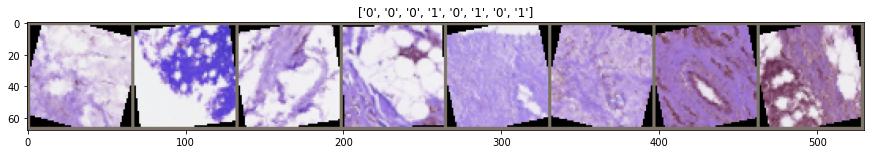

In [15]:
class_names= ['0', '1']
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8,:,:,:])

plt.figure(figsize=(15, 10))
imshow(out, title=[class_names[x] for x in classes[:8]])

## loading pretrained resnet 101

In [ ]:
# fine tune resnet 101 model trained on image net
model = torchvision.models.resnet34(pretrained=True)

In [18]:
fc_in_features = model.fc.in_features
model.fc = nn.Linear(fc_in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## fine tuning model

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.3462 Acc: 0.8545
test Loss: 0.2960 Acc: 0.8767

Epoch 1/29
----------
train Loss: 0.2875 Acc: 0.8783
test Loss: 0.2759 Acc: 0.8835

Epoch 2/29
----------
train Loss: 0.2782 Acc: 0.8824
test Loss: 0.3416 Acc: 0.8586

Epoch 3/29
----------
train Loss: 0.2663 Acc: 0.8874
test Loss: 0.2654 Acc: 0.8882

Epoch 4/29
----------
train Loss: 0.2634 Acc: 0.8888
test Loss: 0.2724 Acc: 0.8848

Epoch 5/29
----------
train Loss: 0.2552 Acc: 0.8932
test Loss: 0.2760 Acc: 0.8854

Epoch 6/29
----------
train Loss: 0.2499 Acc: 0.8950
test Loss: 0.2585 Acc: 0.8903

Epoch 7/29
----------
train Loss: 0.2299 Acc: 0.9032
test Loss: 0.2251 Acc: 0.9058

Epoch 8/29
----------
train Loss: 0.2237 Acc: 0.9062
test Loss: 0.2228 Acc: 0.9058

Epoch 9/29
----------
train Loss: 0.2202 Acc: 0.9077
test Loss: 0.2239 Acc: 0.9080

Epoch 10/29
----------
train Loss: 0.2166 Acc: 0.9093
test Loss: 0.2207 Acc: 0.9078

Epoch 11/29
----------
train Loss: 0.2137 Acc: 0.9106
test Loss: 0.2189 Acc

In [25]:
def visualize_model(model, num_images=16):
    was_training = model.training
    model.eval()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            out = torchvision.utils.make_grid(inputs[:num_images, :, :, :].cpu())
            plt.figure(figsize=(15, 10))
            imshow(out, title=['T:'+str(class_names[lbl])+'->P:'+str(class_names[p]) for lbl, p in zip(labels[:num_images], preds[:num_images])])
            break
        model.train(mode=was_training)

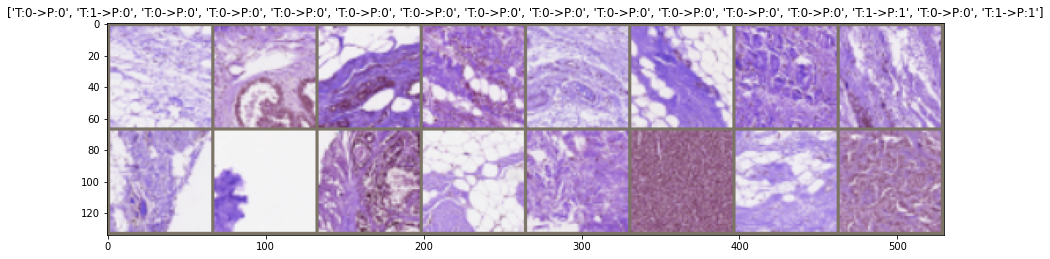

In [27]:
visualize_model(model)